In [27]:

import json
import os
import numpy as np
import matplotlib.pyplot as plt

def process_json(json_file, target_length=400):
    """
    Membaca data dari file JSON dan memastikan semua nilai bertipe float atau np.nan.
    - Jika nilai None di JSON, diganti dengan np.nan.
    - Jika nilai lebih sedikit dari target_length, sisanya diisi dengan np.nan.
    - Jika lebih banyak, dipotong (slice) sesuai target_length.
    """
    if os.path.exists(json_file):
        with open(json_file, 'r') as f:
            data = json.load(f)
        
        # Buat dict dengan key int(episode) dan value float (atau np.nan)
        processed_data = {}
        for k, v in data.items():
            episode_index = int(k)
            if v is None:
                processed_data[episode_index] = np.nan
            else:
                # Pastikan bisa dikonversi ke float
                processed_data[episode_index] = float(v)
        
        # Urutkan berdasarkan episode, lalu ambil nilainya
        sorted_keys = sorted(processed_data.keys())
        sorted_values = [processed_data[k] for k in sorted_keys]

        # Potong/isi agar panjang data sesuai target_length
        adjusted_data = sorted_values[:target_length]
        if len(adjusted_data) < target_length:
            adjusted_data += [np.nan] * (target_length - len(adjusted_data))
        
        return adjusted_data
    else:
        print(f"[Warning] File {json_file} tidak ditemukan. Mengembalikan array np.nan.")
        return [np.nan] * target_length

def rolling_stats(data, window_size=10):
    """
    Menghitung rolling average dan rolling standard deviation untuk data.
    - Abaikan np.nan (tidak ikut dihitung).
    - Hasilnya berupa list yang sama panjang dengan data asli.
    """
    avg_list = []
    std_list = []

    for i in range(len(data)):
        start_idx = max(0, i - window_size + 1)
        window = data[start_idx : i + 1]
        
        # Ambil nilai valid (bukan np.nan)
        valid_vals = [val for val in window if not np.isnan(val)]
        
        if len(valid_vals) > 0:
            mean_val = np.mean(valid_vals)
            std_val  = np.std(valid_vals)
        else:
            mean_val = np.nan
            std_val  = np.nan

        avg_list.append(mean_val)
        std_list.append(std_val)

    return avg_list, std_list

def plot_metrics_with_shadow(json_files, labels,
                             title, xlabel, ylabel,
                             x_tick_interval=50, y_tick_interval=50,
                             target_length=400,
                             window_size=10,
                             y_min=-600, y_max=300
                             ):
    """
    Membuat plot dari beberapa file JSON:
    1. (Raw data TIDAK ditampilkan)
    2. Plot rolling average untuk setiap data.
    3. Tambahkan 'shadow' (fill_between) berdasarkan standard deviation.
    """
    plt.figure(figsize=(10, 8))

    # Rentang episode untuk sumbu x
    x_values = range(target_length)

    for json_file, label in zip(json_files, labels):
        # Ambil data (tidak kita plot raw-nya)
        data = process_json(json_file, target_length)
        
        # Hitung rolling average & std
        avg_list, std_list = rolling_stats(data, window_size=window_size)

        # Plot garis rolling average
        (line,) = plt.plot(x_values, avg_list, label=f"{label}", linewidth=2)

        # Siapkan batas atas dan bawah untuk area shadow
        upper_bound = []
        lower_bound = []
        for m, s in zip(avg_list, std_list):
            if not np.isnan(m) and not np.isnan(s):
                upper_bound.append(m + s)
                lower_bound.append(m - s)
            else:
                upper_bound.append(np.nan)
                lower_bound.append(np.nan)

        # Fill area di sekitar rolling average (shadow)
        plt.fill_between(
            x_values,
            lower_bound,
            upper_bound,
            color=line.get_color(),
            alpha=0.2
        )

    # Konfigurasi sumbu X
    plt.xticks(
        range(0, target_length + 1, x_tick_interval),
        fontsize=12,
        rotation=45
    )

    # Konfigurasi sumbu Y
    plt.yticks(
        np.arange(y_min, y_max + 1, y_tick_interval),
        fontsize=12
    )
    plt.ylim(y_min, y_max)

    # Judul, Label, dan Legenda
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlim(0,100)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(fontsize=12, loc='lower left')
    plt.grid(True, alpha=0.5, linestyle='--')
    plt.tight_layout()
    plt.show()
# Ganti path di bawah dengan path di mana JSON Anda disimpan
#TD3_dir = 'D:/KULIAH/skripsi/CODE/skripsi/1_TD3_origin/saved_models_2_final'
#HITL_dir = 'D:/KULIAH/skripsi/CODE/skripsi/3_HITL/ruled_based_4'

In [28]:
import os
import json
import matplotlib.pyplot as plt

def plot_success_rate(files, labels, reward_threshold=200):
    """
    Membuat barplot untuk success rate dari beberapa file JSON.
    
    Parameter:
      - files: list of str, path ke file JSON. Setiap file JSON berisi dictionary dengan key sebagai episode dan value sebagai reward.
      - labels: list of str, label untuk setiap metode yang sesuai dengan urutan file pada list 'files'.
      - reward_threshold: int atau float, batas reward agar dianggap sukses (default: 200).
    """
    
    # List untuk menyimpan nilai success rate tiap metode
    success_rates = []
    
    # Proses setiap file JSON
    for file in files:
        # Membuka dan membaca file JSON
        with open(file, 'r') as f:
            rewards_dict = json.load(f)
        
        # Inisialisasi counter
        successes = 0
        total = 0
        
        # Iterasi setiap nilai reward dalam dictionary
        for episode, reward in rewards_dict.items():
            try:
                # Pastikan reward dikonversi ke float (jika diperlukan)
                reward_val = float(reward)
            except ValueError:
                # Jika tidak dapat dikonversi, lewati episode tersebut
                continue
            total += 1
            if reward_val > reward_threshold:
                successes += 1
        
        # Hitung success rate jika total episode tidak nol
        if total > 0:
            success_rate = (successes / total) * 100
        else:
            success_rate = 0
        success_rates.append(success_rate)
    
    # Membuat barplot dengan pengaturan agar teks tidak melebihi batas grafik
    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.bar(labels, success_rates, color='skyblue')
    ax.set_ylim(0, 100)
    ax.set_xlabel("Metode")
    ax.set_ylabel("Success Rate (%)")
    ax.set_title(f"Success Rate per Metode (Reward > {reward_threshold} dianggap sukses)")
    
    # Offset teks dari puncak bar
    offset = 2
    # Nilai maksimum agar teks tidak melewati batas grafik (misal, 98)
    max_text_y = 98
    
    # Menampilkan nilai success rate di atas setiap bar dengan pengecekan agar tidak melebihi batas grafik
    for bar, rate in zip(bars, success_rates):
        # Menghitung posisi y untuk teks
        y_text = bar.get_height() + offset
        # Jika posisi y lebih dari batas yang diinginkan, atur ke batas tersebut
        if y_text > max_text_y:
            y_text = bar.get_height() - offset  # Tempatkan di dalam bar jika melebihi batas
            va = 'top'
        else:
            va = 'bottom'
        ax.text(
            bar.get_x() + bar.get_width() / 2, y_text,
            f"{rate:.1f}%", ha='center', va=va, fontsize=10, clip_on=True
        )
    
    # Mengatur margin dan tata letak agar tidak ada teks yang terpotong
    plt.tight_layout()
    plt.show()


# Contoh pemakaian fungsi:
if __name__ == "__main__":
    # Direktori dan file JSON
    env_dir = 'D:\\KULIAH\\skripsi\\CODE\\skripsi\\2_Lunar_Lander'
    DQN_dir = os.path.join(env_dir, '2_Double_DQN', 'D_Testing')
    HITL_DQN_dir = os.path.join(env_dir, '2_Double_DQN', 'D_Testing')


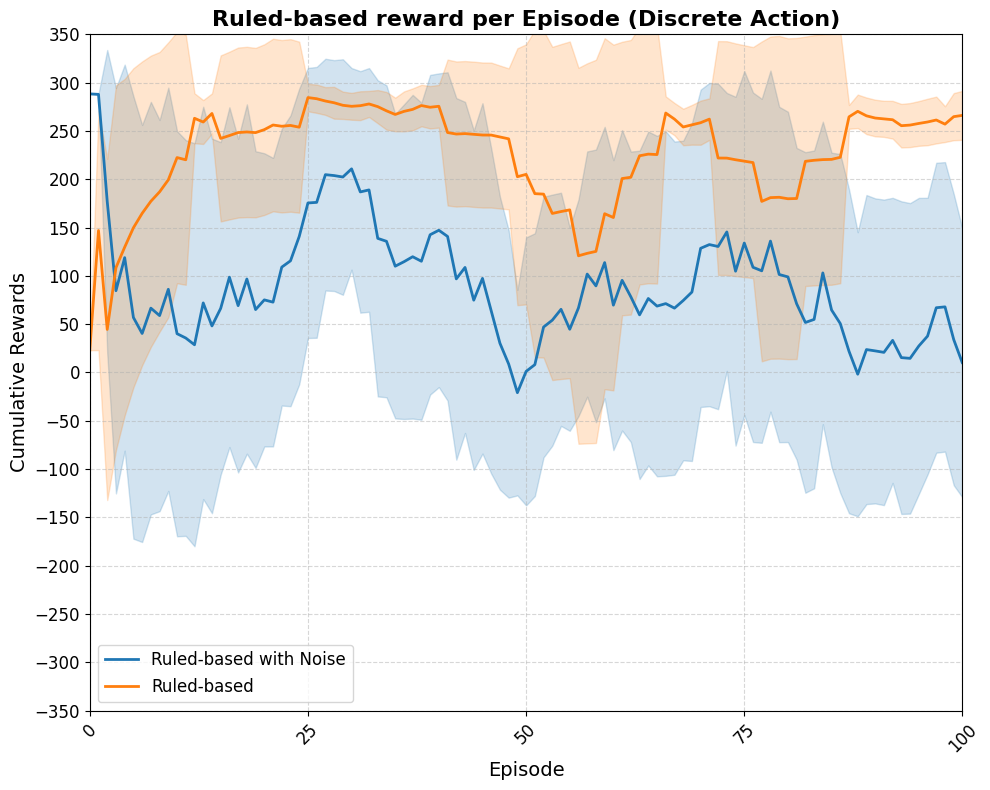

In [29]:
env_dir = 'D:\\KULIAH\\skripsi\\CODE\\skripsi\\2_Lunar_Lander'
noise_diskrit=os.path.join(env_dir, '3_Ruled_Based')
without_noise_diskrit=os.path.join(env_dir, '3_Ruled_Based')

files = [
    os.path.join(noise_diskrit, 'Testing_cumulative_rewards_ruled_based_diskrit_noise.json')
    ,os.path.join(without_noise_diskrit, 'Testing_cumulative_rewards_ruled_based_diskrit_without_noise.json')
]
labels = ['Ruled-based with Noise','Ruled-based']

# Panggil fungsi plot
plot_metrics_with_shadow(
    json_files=files,
    labels=labels,
    title='Ruled-based reward per Episode (Discrete Action)',
    xlabel='Episode',
    ylabel='Cumulative Rewards',
    x_tick_interval=25,
    y_tick_interval=50,
    target_length=400,  # Sesuaikan jika perlu panjang data berbeda
    window_size=10,      # Lebar jendela rolling average/std
    y_min=-350,
    y_max=350,
)

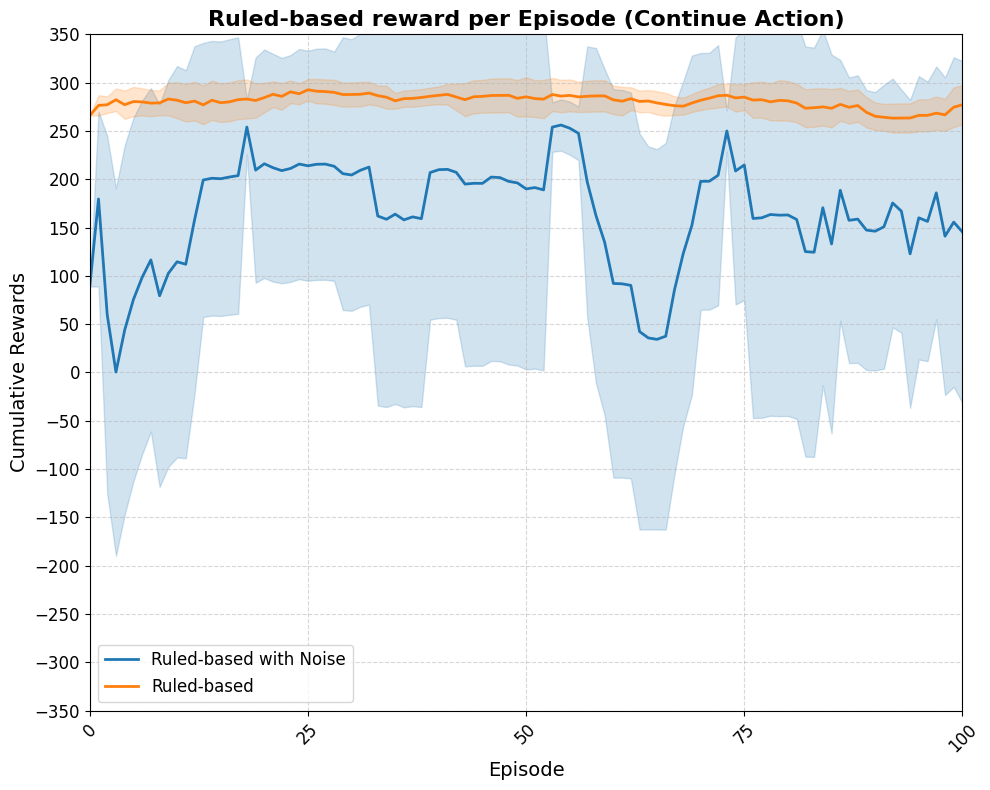

In [30]:
env_dir = 'D:\\KULIAH\\skripsi\\CODE\\skripsi\\2_Lunar_Lander'
noise_diskrit=os.path.join(env_dir, '3_Ruled_Based')
without_noise_diskrit=os.path.join(env_dir, '3_Ruled_Based')

files = [
    os.path.join(noise_diskrit, 'Testing_cumulative_rewards_ruled_based_kontinu_noise.json')
    ,os.path.join(without_noise_diskrit, 'Testing_cumulative_rewards_ruled_based_kontinu_without_noise.json')
]
labels = ['Ruled-based with Noise','Ruled-based']

# Panggil fungsi plot
plot_metrics_with_shadow(
    json_files=files,
    labels=labels,
    title='Ruled-based reward per Episode (Continue Action)',
    xlabel='Episode',
    ylabel='Cumulative Rewards',
    x_tick_interval=25,
    y_tick_interval=50,
    target_length=400,  # Sesuaikan jika perlu panjang data berbeda
    window_size=10,      # Lebar jendela rolling average/std
    y_min=-350,
    y_max=350,
)

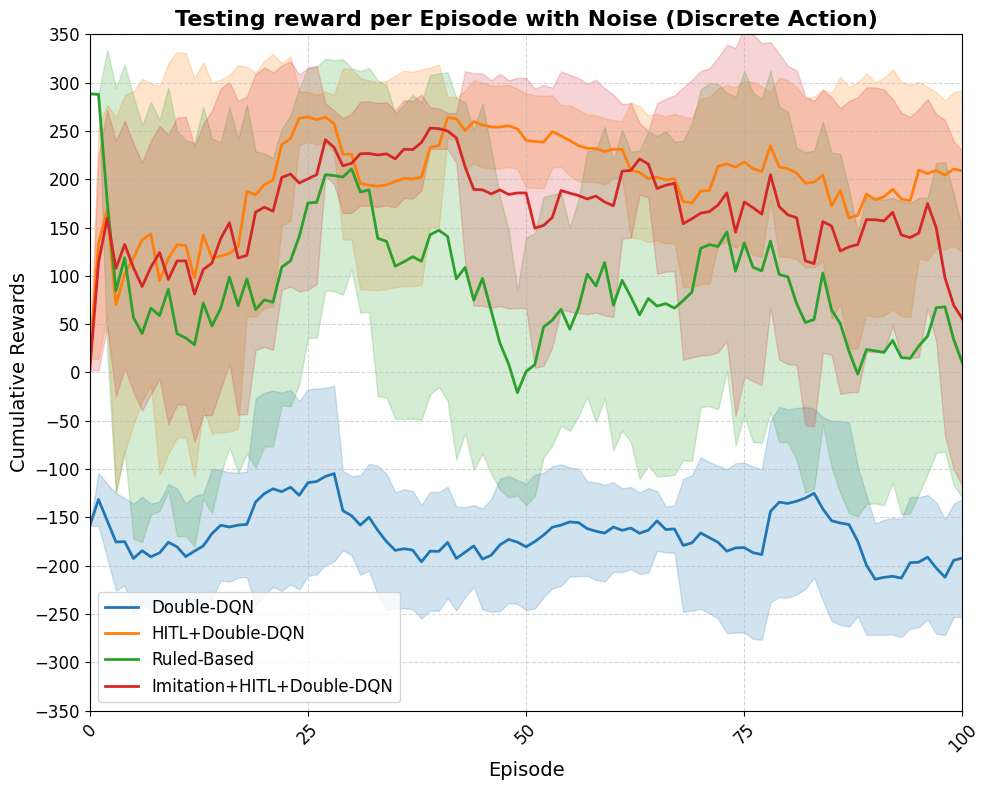

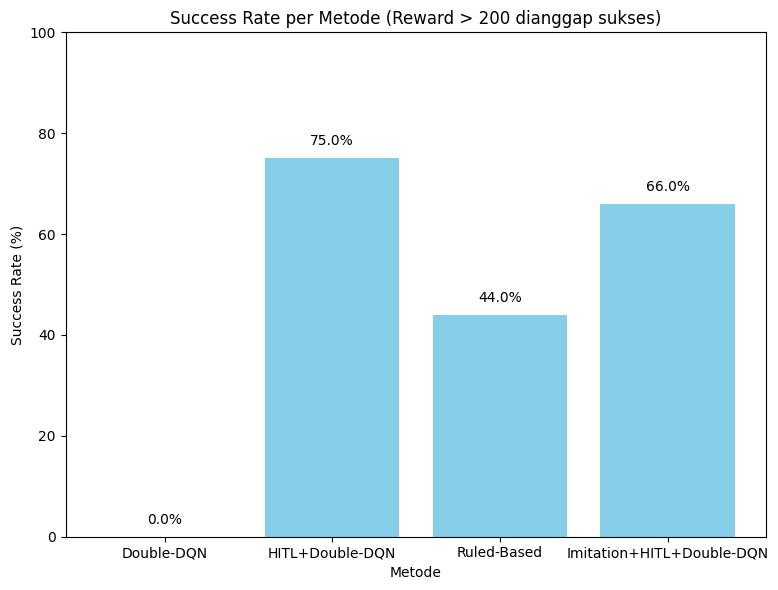

In [31]:
env_dir = 'D:\\KULIAH\\skripsi\\CODE\\skripsi\\2_Lunar_Lander'
DQN_dir = os.path.join(env_dir, '2_Double_DQN', 'D_Testing')
HITL_DQN_dir =os.path.join(env_dir, '2_Double_DQN', 'D_Testing')
Ruled_Based_dir=os.path.join(env_dir, '3_Ruled_Based')
HG_DQN_dir=os.path.join(env_dir, '2_Double_DQN', 'D_Testing')

files = [
    os.path.join(DQN_dir, 'Testing_cumulative_rewards_DDQN_noise.json'),
    os.path.join(HITL_DQN_dir, 'Testing_cumulative_rewards_DDQN_HITL_noise.json'),
    os.path.join(Ruled_Based_dir, 'Testing_cumulative_rewards_ruled_based_diskrit_noise.json'),
    os.path.join(HG_DQN_dir, 'Testing_cumulative_rewards_DDQN_HG_noise.json')
]
labels = ['Double-DQN','HITL+Double-DQN', 'Ruled-Based', 'Imitation+HITL+Double-DQN']

# Panggil fungsi plot
plot_metrics_with_shadow(
    json_files=files,
    labels=labels,
    title='Testing reward per Episode with Noise (Discrete Action)',
    xlabel='Episode',
    ylabel='Cumulative Rewards',
    x_tick_interval=25,
    y_tick_interval=50,
    target_length=400,  # Sesuaikan jika perlu panjang data berbeda
    window_size=10,      # Lebar jendela rolling average/std
    y_min=-350,
    y_max=350,
)
plot_success_rate(files, labels, reward_threshold=200)

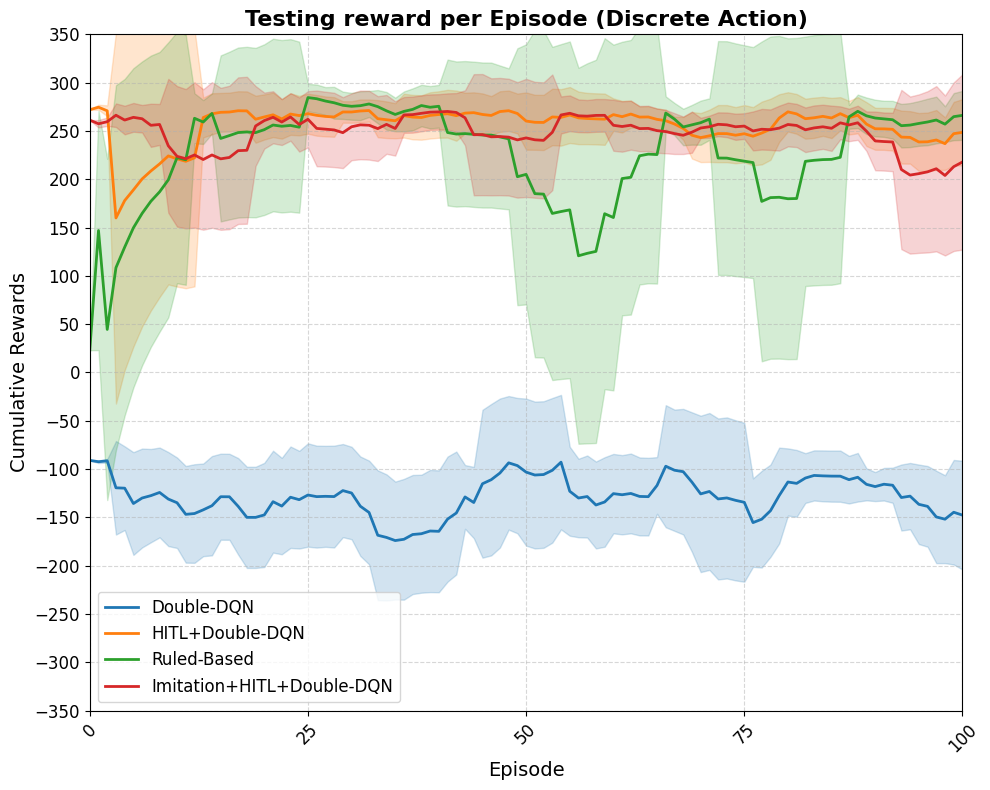

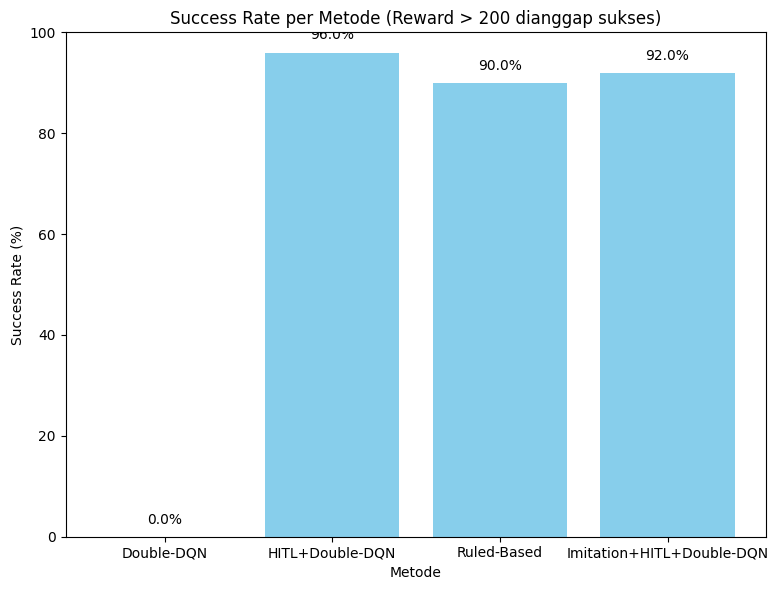

In [32]:
env_dir = 'D:\\KULIAH\\skripsi\\CODE\\skripsi\\2_Lunar_Lander'
DQN_dir = os.path.join(env_dir, '2_Double_DQN', 'D_Testing')
HITL_DQN_dir =os.path.join(env_dir, '2_Double_DQN', 'D_Testing')
Ruled_Based_dir=os.path.join(env_dir, '3_Ruled_Based')
HG_DQN_dir=os.path.join(env_dir, '2_Double_DQN', 'D_Testing')

files = [
    os.path.join(DQN_dir, 'Testing_cumulative_rewards_DDQN_without_noise.json'),
    os.path.join(HITL_DQN_dir, 'Testing_cumulative_rewards_DDQN_HITL_without_noise.json'),
    os.path.join(Ruled_Based_dir, 'Testing_cumulative_rewards_ruled_based_diskrit_without_noise.json'),
    os.path.join(HG_DQN_dir, 'Testing_cumulative_rewards_DDQN_HG_without_noise.json')
]
labels = ['Double-DQN','HITL+Double-DQN', 'Ruled-Based', 'Imitation+HITL+Double-DQN']

# Panggil fungsi plot
plot_metrics_with_shadow(
    json_files=files,
    labels=labels,
    title='Testing reward per Episode (Discrete Action)',
    xlabel='Episode',
    ylabel='Cumulative Rewards',
    x_tick_interval=25,
    y_tick_interval=50,
    target_length=400,  # Sesuaikan jika perlu panjang data berbeda
    window_size=10,      # Lebar jendela rolling average/std
    y_min=-350,
    y_max=350,
)
plot_success_rate(files, labels, reward_threshold=200)

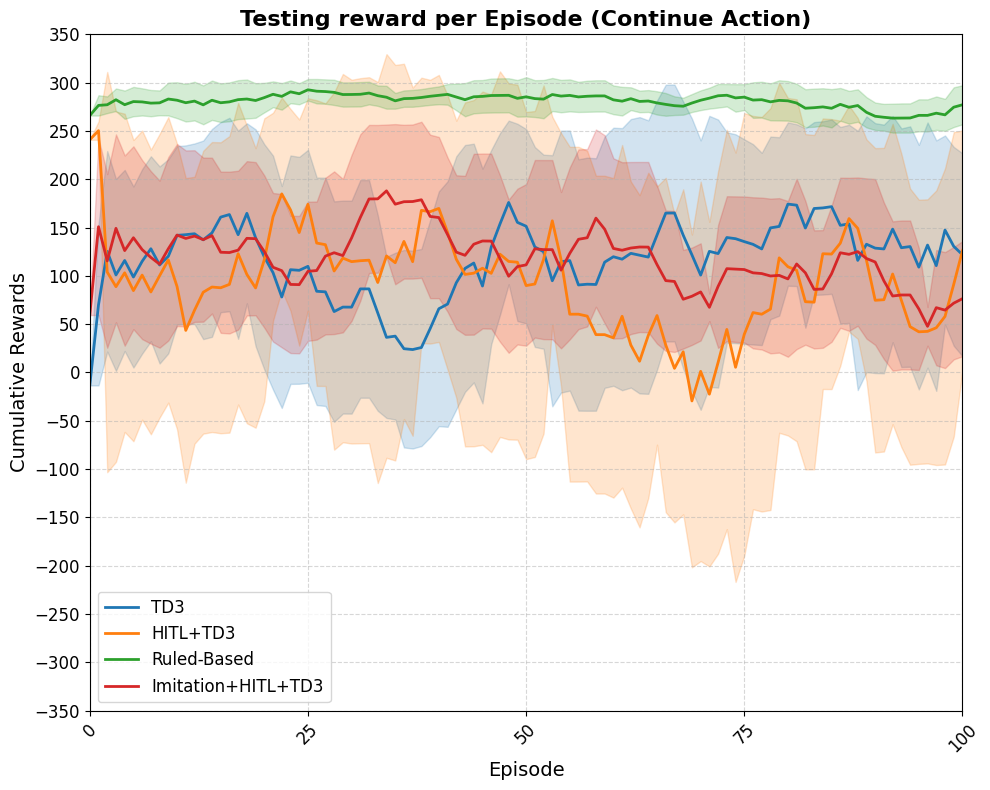

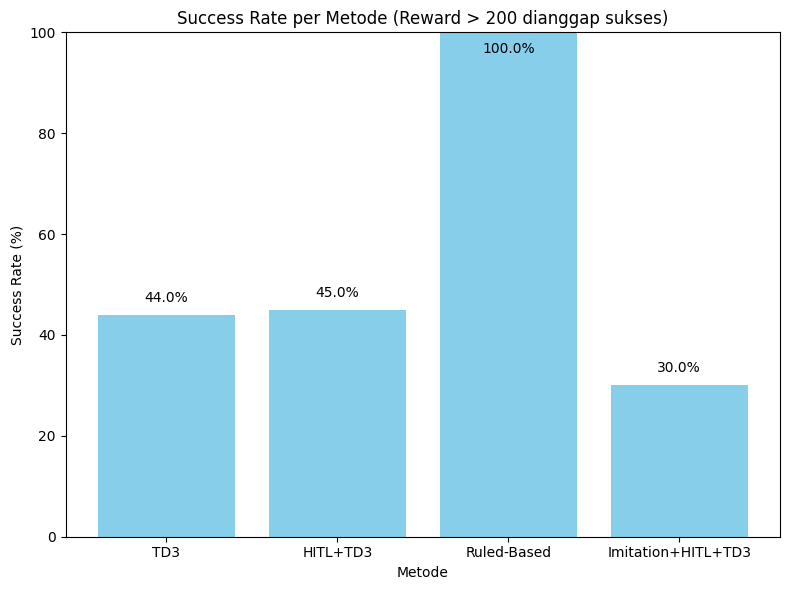

In [33]:
env_dir = 'D:\\KULIAH\\skripsi\\CODE\\skripsi\\2_Lunar_Lander'
TD3_dir= os.path.join(env_dir, '1_TD3', 'D_Testing')
HITL_TD3_dir =os.path.join(env_dir, '1_TD3', 'D_Testing')
Ruled_Based_dir=os.path.join(env_dir, '3_Ruled_Based')
HG_TD3_dir=os.path.join(env_dir, '1_TD3', 'D_Testing')

files = [
    os.path.join(TD3_dir, 'Testing_cumulative_rewards_TD3_without_noise.json'),
    os.path.join(HITL_TD3_dir , 'Testing_cumulative_rewards_TD3_HITL_without_noise.json'),
    os.path.join(Ruled_Based_dir, 'Testing_cumulative_rewards_ruled_based_kontinu_without_noise.json'),
    os.path.join(HG_TD3_dir, 'Testing_cumulative_rewards_TD3_HG_without_noise.json'),


]
labels = ['TD3','HITL+TD3', 'Ruled-Based', 'Imitation+HITL+TD3']

# Panggil fungsi plot
plot_metrics_with_shadow(
    json_files=files,
    labels=labels,
    title='Testing reward per Episode (Continue Action)',
    xlabel='Episode',
    ylabel='Cumulative Rewards',
    x_tick_interval=25,
    y_tick_interval=50,
    target_length=400,  # Sesuaikan jika perlu panjang data berbeda
    window_size=10,      # Lebar jendela rolling average/std
    y_min=-350,
    y_max=350,
)
plot_success_rate(files, labels, reward_threshold=200)

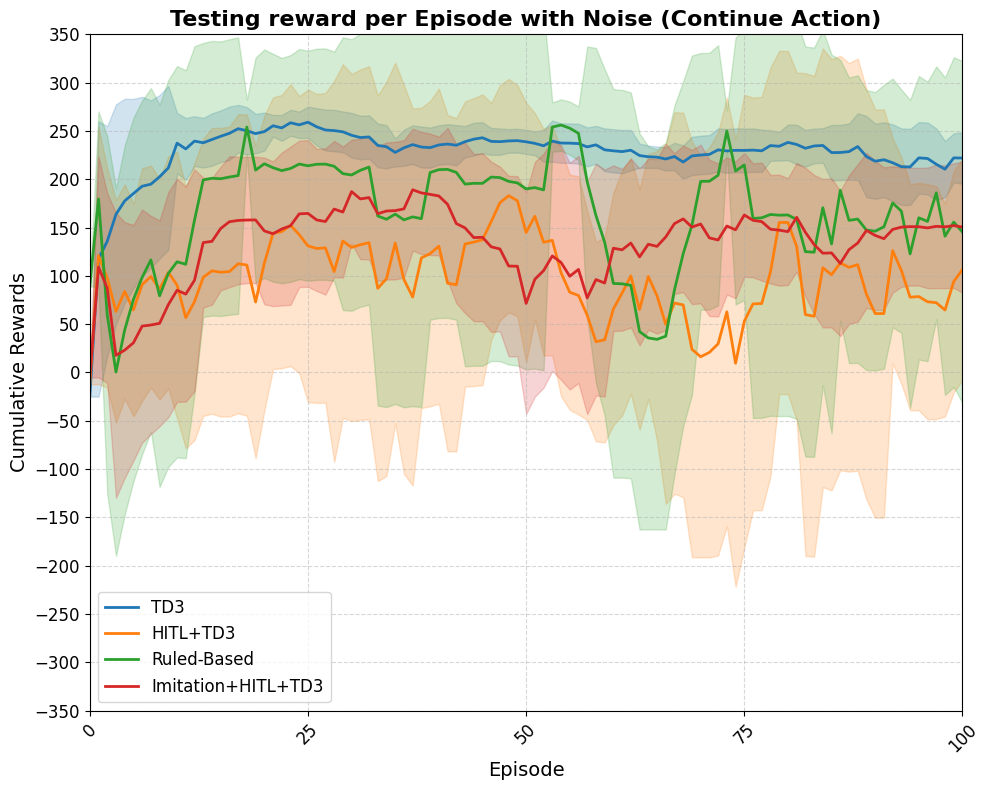

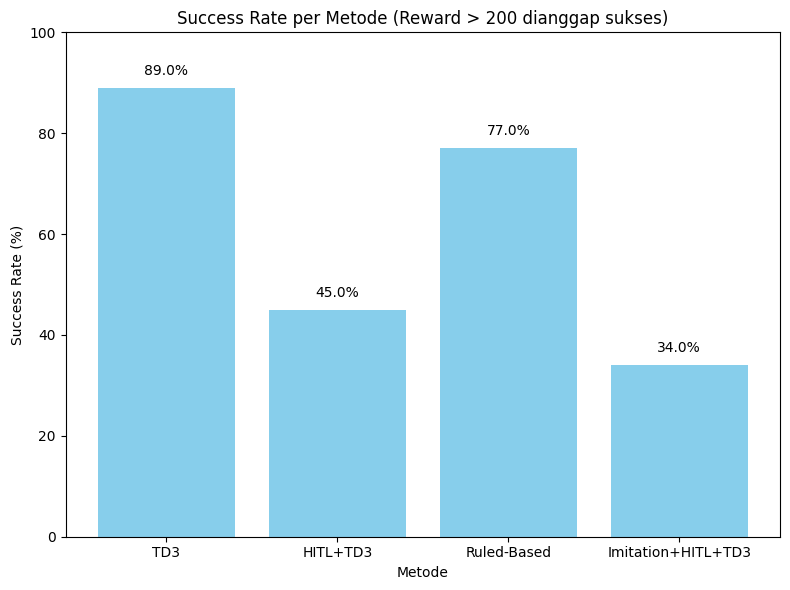

In [34]:
env_dir = 'D:\\KULIAH\\skripsi\\CODE\\skripsi\\2_Lunar_Lander'
TD3_dir= os.path.join(env_dir, '1_TD3', 'D_Testing')
HITL_TD3_dir =os.path.join(env_dir, '1_TD3', 'D_Testing')
Ruled_Based_dir=os.path.join(env_dir, '3_Ruled_Based')
HG_TD3_dir=os.path.join(env_dir, '1_TD3', 'D_Testing')

files = [
    os.path.join(TD3_dir, 'Testing_cumulative_rewards_TD3_noise.json'),
    os.path.join(HITL_TD3_dir , 'Testing_cumulative_rewards_TD3_HITL_noise.json'),
    os.path.join(Ruled_Based_dir, 'Testing_cumulative_rewards_ruled_based_kontinu_noise.json'),
    os.path.join(HG_TD3_dir, 'Testing_cumulative_rewards_TD3_HG_noise.json'),
]
labels = ['TD3','HITL+TD3', 'Ruled-Based', 'Imitation+HITL+TD3']

# Panggil fungsi plot
plot_metrics_with_shadow(
    json_files=files,
    labels=labels,
    title='Testing reward per Episode with Noise (Continue Action)',
    xlabel='Episode',
    ylabel='Cumulative Rewards',
    x_tick_interval=25,
    y_tick_interval=50,
    target_length=400,  # Sesuaikan jika perlu panjang data berbeda
    window_size=10,      # Lebar jendela rolling average/std
    y_min=-350,
    y_max=350,
)
plot_success_rate(files, labels, reward_threshold=200)